In [2]:
import pylab as p
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from pyspikelib import TrainNormalizeTransform
from pyspikelib import TsfreshVectorizeTransform
from pyspikelib import TsfreshFeaturePreprocessorPipeline
from pyspikelib.utils import simple_undersampling
import pyspikelib.mpladeq as mpladeq

from dataset_adapters import fcx1_dataset

mpladeq.beautify_mpl()

import warnings
warnings.filterwarnings('ignore')

In [3]:
! ls ../data/

allen		       fcx1_data.tar  sleep.parq     wake.parq
data_download_link.md  README.md      sleep.parq.gz  wake.parq.gz


In [4]:
! cd ../data; tar -xvf ../data/fcx1_data.tar ./

./README.md
./sleep.parq.gz
./wake.parq.gz


In [9]:
! gzip -df ../data/sleep.parq.gz; gzip -df ../data/wake.parq.gz 

In [6]:
datapath = Path('../data/')
wake_spikes = fcx1_dataset(datapath / 'wake.parq')
sleep_spikes = fcx1_dataset(datapath / 'sleep.parq')

In [7]:
group_split = GroupShuffleSplit(n_splits=1, test_size=0.5)
X = np.hstack([wake_spikes.series.values, sleep_spikes.series.values])
y = np.hstack([np.ones(wake_spikes.shape[0]), np.zeros(sleep_spikes.shape[0])])
groups = np.hstack([wake_spikes.groups.values, sleep_spikes.groups.values])

for train_index, test_index in group_split.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X_train = pd.DataFrame({'series': X_train, 'groups': groups[train_index]})
X_test = pd.DataFrame({'series': X_test, 'groups': groups[test_index]})

Text(0, 0.5, 'ISI value, ms')

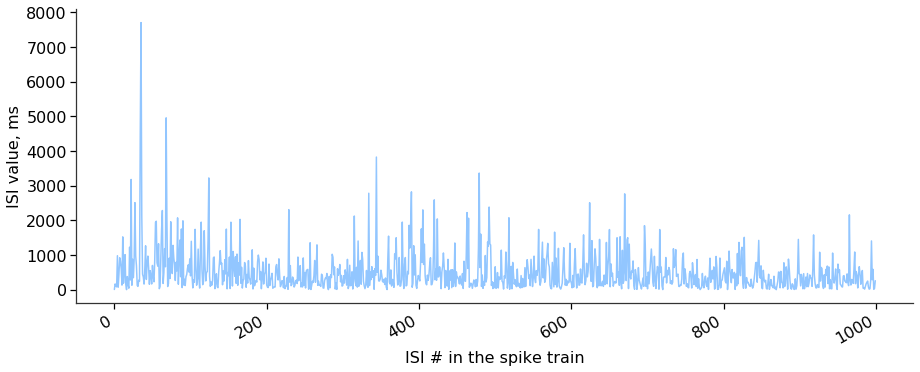

In [10]:
string_to_float = lambda string: [float(value) for value in string.split(',')]
train = string_to_float(X_train.series.values[0])

p.plot(train[:1000])
mpladeq.prettify((15, 6))
p.xlabel('ISI # in the spike train')
p.ylabel('ISI value, ms')

In [11]:
def prepare_tsfresh_data(X, y):
    """Extract and preprocess tsfresh features from spiking data"""
    normalizer = TrainNormalizeTransform(window=20, step=20, n_samples=1000)
    X, y = normalizer.transform(X, y, delimiter=',')
    vectorizer = TsfreshVectorizeTransform(feature_set=None)
    X = vectorizer.transform(X)
    return X, y

In [12]:
X_train, y_train = prepare_tsfresh_data(X_train, y_train)
X_test, y_test = prepare_tsfresh_data(X_test, y_test)

preprocessing = TsfreshFeaturePreprocessorPipeline().construct_pipeline()
preprocessing.fit(X_train)
X_train = preprocessing.transform(X_train)
X_test = preprocessing.transform(X_test)

Feature Extraction: 100%|██████████| 143/143 [00:08<00:00, 17.11it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_tre

 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend

In [21]:
X_train, y_train = simple_undersampling(X_train, y_train)
X_test, y_test = simple_undersampling(X_test, y_test)

print('Target mean | train: {} test: {}'.format(y_train.mean(), y_test.mean()))
print('Dataset shape | train: {} test: {}'.format(X_train.shape, X_test.shape))

Target mean | train: 0.5 test: 0.5
Dataset shape | train: (1248, 315) test: (1306, 315)


In [15]:
forest = RandomForestClassifier(n_estimators=200,
                                random_state=42,
                                n_jobs=-1)


forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [18]:
'Accuracy score of RF: {}'.format(accuracy_score(y_test, forest.predict(X_test)))

'Accuracy score of RF: 0.6094946401225115'

In [19]:
importance = pd.DataFrame()
importance['feature'] = X_train.columns.values
importance['importance_score'] = forest.feature_importances_

In [20]:
importance.sort_values(by='importance_score', ascending=False).head(20)

,feature,importance_score
190,"value__fft_aggregated__aggtype_""kurtosis""",0.019757
283,value__quantile__q_0.1,0.017865
298,value__sample_entropy,0.017609
54,value__binned_entropy__max_bins_10,0.013061
284,value__quantile__q_0.2,0.010079
33,value__approximate_entropy__m_2__r_0.1,0.009784
285,value__quantile__q_0.3,0.008662
114,"value__change_quantiles__f_agg_""var""__isabs_Tr...",0.008586
267,value__minimum,0.008438
266,value__median,0.007997
